In [2]:
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob

# For our model
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sys import platform
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from tunedColorizer import colorizer
# from cnnColorizer import colorizer, trainModel
from pytorchtool import EarlyStopping


In [59]:
class colorer(nn.Module):
    def __init__(self):
        super(colorer, self).__init__()
        
#         outSize = [8, 16, 32, 128, 256, 128, 32, 16, 8]
        outSize = [128, 256, 256, 200, 128, 64, 32, 16, 4] 
#         outSize = [2, 4, 8, 16, 32, 16, 8, 4, 2]
#         outSize = [4, 16, 32, 64, 128, 200, 256, 256, 128]
    
        #128x128
        self.downsamp1 = nn.Sequential(
             nn.Conv2d(1, outSize[0], kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
             nn.BatchNorm2d(outSize[0]),
            # nn.AvgPool2d(kernel_size = (1,1), stride = 1)
             )
        #64x64
        self.downsamp2 = nn.Sequential(
             nn.Conv2d(outSize[0], outSize[1], kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
             nn.BatchNorm2d(outSize[1]),
           #  nn.AvgPool2d(kernel_size = (1,1), stride = 1)
             )
        #32x32
        self.downsamp3 = nn.Sequential(
             nn.Conv2d(outSize[1], outSize[2], kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
             nn.BatchNorm2d(outSize[2]),
          #   nn.AvgPool2d(kernel_size = (1,1), stride = 1)
             )
        #16x16
        self.downsamp4 = nn.Sequential(
             nn.Conv2d(outSize[2], outSize[3], kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
             nn.BatchNorm2d(outSize[3]),
          #   nn.AvgPool2d(kernel_size = (1,1), stride = 1)
             )
        #8x8
        self.downsamp5 = nn.Sequential(
             nn.Conv2d(outSize[3], outSize[4], kernel_size = 3, stride = 2, padding = 1),
             nn.ReLU(),
             nn.BatchNorm2d(outSize[4]),
          #   nn.AvgPool2d(kernel_size = (1,1), stride = 1)
             )
        
        #begin upsampling here
        #using convolution transpose
        #8x8
        self.upsamp1 = nn.Sequential(        
             nn.ConvTranspose2d(outSize[4], outSize[5], kernel_size = 2, stride = 2),
             nn.BatchNorm2d(outSize[5]),
             )
        
        #16x16
        self.upsamp2 = nn.Sequential(         
             nn.ConvTranspose2d(outSize[5], outSize[6], kernel_size = 2, stride = 2),
             nn.BatchNorm2d(outSize[6]),
             )
        
        #32x32
        self.upsamp3 = nn.Sequential(
            nn.ConvTranspose2d(outSize[6], outSize[7], kernel_size = 2, stride = 2),    
            nn.BatchNorm2d(outSize[7]),
            )
        
        #64x64
        self.upsamp4 = nn.Sequential(
            nn.ConvTranspose2d(outSize[7], outSize[8], kernel_size = 2, stride = 2),    
            nn.BatchNorm2d(outSize[8]),
            )
        
         #128x128
         #keep at 2 channels
        self.upsamp5 = nn.Sequential(
            nn.ConvTranspose2d(outSize[8], 2, kernel_size = 2, stride = 2),         
            )
           

    def forward(self, x):

        x = x.float()
        out = self.downsamp1(x)
        out = self.downsamp2(out)
        out = self.downsamp3(out)
        out = self.downsamp4(out)
        out = self.downsamp5(out)
        out = self.upsamp1(out)
        out = self.upsamp2(out)
        out = self.upsamp3(out)
        out = self.upsamp4(out)
        out = self.upsamp5(out)

        #collapse dimension 1 along dimension 0 using flatten
        out = torch.flatten(out, 0, 1)
        return out
    
    

### Helper Functions

In [4]:
def load(folder):
    files = glob.glob(folder)
    data =[]
    for f in files:
        image = cv2.imread(f)
        data.append(image)
    return data


def LoadLabInOrder(folder):

    # find the largest number file to index (do not worry about how these next few lines work)
    files = glob.glob(folder + "*L.jpg")
    for i, f in enumerate(files):
        f = f[f.rfind('/')+1:]
        files[i] = f[0:f.rfind('.')-1]
    maxFileNum = max([int(f) for f in files])
    
    # for each file index (e.g. ['0a.jpg', '0b.jpg', '0L.jpg'])
    data = []
    for i in range(0, maxFileNum):
        # grab files in order 'a', 'b', 'L'
        files = sorted(glob.glob(folder + str(i) + "?.jpg"), key=str.casefold)

        # append each file
        for f in files:
            image = cv2.imread(f)

            # only take one channel (all the channels here are the same)
            data.append(image)
        
    return data


def group(data, album_length):
    #group into chunks of three because of three sets of images in LAB color space
    for i in range (0, album_length, 3):
        yield data[i:i+3]
  
def make_numpy_format(image):
    image = torch.swapaxes(image, 0, 1)
    image = torch.swapaxes(image, 1, 2)
    return image

def make_tensor(image):
    image = np.swapaxes(image, 2,1)
    image = np.swapaxes(image, 1,0)
    return image


class imageDataset(Dataset):
    def __init__(self,  l_color_space, ab_color_space,):
        #dropping redundant channels
        a = (ab_color_space[:, 0])
        b = (ab_color_space[:, 1])
        l = (l_color_space)
        

        #it seems that I will have to use permute 
        #to get from numpy image representation
        #to torch tensor image 
        
        self.a = a
        self.b = b
        self.l = l
        self.indices = len(l)
        
    def __len__(self):
        return self.indices
      
    
    def __getitem__(self, index):
        return self.a[index], self.b[index], self.l[index]    
    
    
def convert_LAB(album):
    converted_album = [[] for _ in range( len(album))]
    
    #code borrowed from https://towardsdatascience.com/computer-vision-101-working-with-color-images-in-python-7b57381a8a54
    for index, image in enumerate(album):
        #do LAB conversion here
        image = np.asarray(image).astype('uint8')
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        names = []
        channels = []
        
        for (name, chan) in zip(("L", "a", "b"), cv2.split(converted_image)):
            names.append(name)
            channels.append(chan)
           # cv2.imshow(name, chan)
           
        converted_album[index] = list(zip(names, channels))
              
    return converted_album
        
def saveLAB(album, folder_name):
    subfolder_dir = os.path.join(os.getcwd(), folder_name)
    
    if not os.path.exists(subfolder_dir):
        os.mkdir(subfolder_dir)

    count = 0
    #each entry inside an LAB color space album is a tuple
    for tup in album:
       # image = image.cpu().detach().numpy()
       names, channels = zip(*tup)
       
       for i in range(len(channels)):
           name = names[i]
           channel = channels[i]
           cv2.imwrite(subfolder_dir + slash + str(count) + name + '.jpg', channel)
           
      
       count +=1


### Get Original Images, Convert to Lab, Save

In [5]:
if platform == 'darwin':
    slash = '/'
else: 
    slash = '\\'

    
home_dir = os.getcwd() 

#change this parameter depending on which album you want
target_album = 'ColorfulLab'
if target_album == 'LAB_TEST_FACES':
    album = 'faces'
else:
    album = 'ColorfulLab'

# if the specified directory does not exist, or if it exists but is empty
if not os.path.exists(home_dir + slash + target_album) \
    or (os.path.exists(home_dir + slash + target_album) and not [name for name in os.listdir("." + slash + target_album)]):

    # get names of folders for colorful fruit data
    foodFolders = [name for name in os.listdir("." + slash + target_album)]

    # get fruit images
    food_images = []
    for ff in foodFolders:
        food_images.extend(load(home_dir + slash + target_album + slash + ff + slash + '*.jpg'))

    # album_length = len(food_images)

    for i, val in enumerate(food_images):
        food_images[i] = cv2.resize(val, (128, 128))
    food_images_lab = convert_LAB(food_images)
    saveLAB(food_images_lab, "ColorfulLab")

    # plot rgb image
#     plt.imshow(cv2.cvtColor(food_images[0], cv2.COLOR_BGR2RGB))

### Load Images

In [6]:
batch_size = 32
Epochs = 100
lr = 0.01
criterion = nn.MSELoss()
torch.set_default_tensor_type(torch.FloatTensor)

home_dir = os.getcwd() 
#change this parameter depending on which album you want
target_album = 'ColorfulLab'
if target_album == 'LAB_TEST_FACES':
    album = 'faces'
else:
    album = 'ColorfulLab'


food_data = LoadLabInOrder(home_dir + slash + target_album + slash)
album_length = len(food_data)

#group images into sets of 3   
food_grouped_data = list(group(food_data, album_length))
food_grouped_data = np.asarray(food_grouped_data)
    
#prepare grouped data for training and test
food_train_images, food_test_images = train_test_split(food_grouped_data, test_size = 0.3)
food_train_images, food_val_images = train_test_split(food_train_images, test_size = 0.1)

#further separate them into X's and Y's where L is the input and AB are the targets (LAB colorspace)
#remember the dimensions are Number of grouped images X Index of image
#this needs to be flipped

food_X_train = food_train_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_train = food_train_images[:, 0:2, :, :, 0]#.astype(dtype=object)

food_X_test = food_test_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_test = food_test_images[:, 0:2, :, :, 0]#.astype(dtype=object)

food_X_val = food_test_images[:, 2, :, :, 0]#.astype(dtype=object)
food_y_val = food_test_images[:, 0:2, :, :, 0]#.astype(dtype=object)


#prepare datasets for images
food_train_dataset = imageDataset(food_X_train, food_y_train)
food_test_dataset = imageDataset(food_X_test, food_y_test)
food_val_dataset = imageDataset(food_X_val, food_y_val)

# prepare dataloaders for batch training
food_train_loader = torch.utils.data.DataLoader(dataset = food_train_dataset, batch_size = batch_size, shuffle=True)
food_test_loader = torch.utils.data.DataLoader(dataset = food_test_dataset,  batch_size = batch_size, shuffle=True)
food_val_loader = torch.utils.data.DataLoader(dataset = food_val_dataset,  batch_size = batch_size, shuffle=True)


In [7]:
# def my_collate(batch):
#     for i, val in enumerate(batch):
#         print(val[0].shape)
#         print(val[1].shape)
#         print(val[2].shape)
            
#     data = [item[0] for item in batch]
#     target1 = [item[1] for item in batch]
#     target2 = [item[2] for item in batch]
#     target = torch.Tensor([target1, target2])
#     return [data, target]


# # #prepare dataloaders for batch training
# food_train_loader = torch.utils.data.DataLoader(dataset = food_train_dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
# food_test_loader = torch.utils.data.DataLoader(dataset = food_test_dataset,  batch_size = batch_size, shuffle=True, collate_fn=my_collate)
# food_val_loader = torch.utils.data.DataLoader(dataset = food_val_dataset,  batch_size = batch_size, shuffle=True, collate_fn=my_collate)

In [8]:
def trainModel(color, trainLoader, valLoader, optimizer, epochs, album, album_num):

    patience = 20
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    if not os.path.exists('.' + slash + f'chkpt_{album}' + slash + f'try{album_num}'):
        os.mkdir('.' + slash + f'chkpt_{album}' + slash + f'try{album_num}')
    
    #training loop: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    #loss_values = []
    train_loss = []
    validation_loss = []
    val_ticker = 0
    last_loss = 20000

    # rows, cols = (2, Epochs)
    # stored_images = [[0 for i in range(cols)] for j in range(rows)]

    for epoch in range(epochs):  # loop over the dataset multiple times
        color.train()
    
        running_loss = 0.0
        #I want batch to be of length 10 not 3 why?
        for i, img in enumerate(trainLoader):
            
            a = img[0] # i changed these for clarity and less typing i didn't want to type batch everytime -hmk
            b = img[1]
            l = img[2]
            
            #each batch is ten images so loop through all the images per batch
            # no!!!! this defeats the point of batches if you loop through each image you've essentially made your batch size 1 -hmk
            
            # for index, images in enumerate(batch):
                # get the inputs; data is a list of tensors [chrominance_a_tensor, chrominance_b_tensor, grayscale_l_tensor]
                # different images!
        
        
            #labels = torch.tensor((label_a, label_b))
            #might not be necessary to drop duplicates
            labels = torch.stack((a, b), 1).float().to(device)
            input_l = torch.unsqueeze(l, 1).to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = color((input_l))
            # outputs = outputs.view(2, size)
                        
            #flatten labels along dimension 0
            labels = torch.flatten(labels, 0, 1)

            loss = criterion(outputs, labels)
        
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
                    
        train_loss.append(loss)

#         if epoch % 10 == 0:
        running_val_loss = 0.0
        with torch.no_grad():
            color.eval()
            for data in valLoader:
                val_l = torch.unsqueeze(data[2], 1).to(device)
                val_outputs = color(val_l)
                val_labels = torch.stack((data[0], data[1]), 1).float().to(device)
                val_loss = criterion(val_outputs, torch.flatten(val_labels, 0, 1))
                running_val_loss += val_loss

        validation_loss.append(running_val_loss)
        print("\nNumber Of Images Tested =", len(valLoader)*batch_size)
        print("Validation MSE Loss =", (running_val_loss/len(valLoader)))

        if epoch % 10 == 0:
            if (running_val_loss/len(valLoader)) - last_loss >= 0.1:
                path = f"./chkpt_{album}/try{album_num}/color_model_{epoch}.pt"
                torch.save(color.state_dict(), path)
        last_loss = (running_val_loss/len(valLoader))

        if epoch % 10 == 0:
            # once done with a loop I want to print out the target image 
            # # and colorized image for comparison    
            sample_target = cv2.merge([l[0].detach().numpy(), a[0].detach().numpy(), b[0].detach().numpy()]) 
            sample_target = cv2.cvtColor(sample_target, cv2.COLOR_LAB2RGB)
            plt.figure()
            plt.imshow(sample_target)

            sample_target = cv2.merge([l[0].cpu().detach().numpy(), a[0].cpu().detach().numpy(), b[0].cpu().detach().numpy()]) 
            sample_target = cv2.cvtColor(sample_target, cv2.COLOR_LAB2RGB)
            #plt.imshow(sample_target)

            colorized_a = outputs[0].cpu().detach().numpy().astype(np.uint8)
            colorized_b = outputs[1].cpu().detach().numpy().astype(np.uint8)
            sample_colorized = cv2.merge([l[0].detach().numpy(), colorized_a, colorized_b])
            sample_colorized = cv2.cvtColor(sample_colorized, cv2.COLOR_LAB2RGB)
            plt.figure()
            plt.imshow(sample_colorized)                   # dont need these anymore bc im just saving the images as pngs instead -hmk
            # stored_images[0][epoch] = sample_target
            # stored_images[1][epoch] = sample_colorized
            cv2.imwrite(f"./chkpt_{album}/try{album_num}/images/target_image_{epoch}.png",sample_target)
            cv2.imwrite(f"./chkpt_{album}/try{album_num}/images/output_image_{epoch}.png",sample_colorized) # -hmk

        
        # use early stopping to prevent overfitting
        early_stopping(running_val_loss/len(valLoader), color)
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        print('Epoch {} of {}, Training MSE Loss: {:.3f}'.format( epoch+1, epochs, running_loss/len(trainLoader)))


    # load and return the last checkpoint with the best model
#     return colorer().load_state_dict(torch.load('checkpoint.pt'))

### Train the Model

In [ ]:
# from cnnColorizer import colorizer
# cModel = torch.load('../saved_models/model_architecture_11.pt')
path = "./saved_models/color_architecture_9.pt"
cModel = colorer()
cModel.load_state_dict(torch.load(path))

cModel.eval()

# allow training of weights for first layer
cModel.downsamp1.requires_grad=False

# freeze layer weights
cModel.downsamp2.requires_grad=False
cModel.downsamp3.requires_grad=False
cModel.downsamp4.requires_grad=False
cModel.downsamp5.requires_grad=False
cModel.upsamp1.requires_grad=False
cModel.upsamp2.requires_grad=False
cModel.upsamp3.requires_grad=False

# # add average pool to 4th upsample layer
# cModel.upsamp4 = nn.Sequential(
#     nn.ConvTranspose2d(16, 4, kernel_size = 2, stride = 2),    
#     nn.BatchNorm2d(4),
#     nn.AvgPool2d(kernel_size = (1,1), stride = 1)
#     )

# allow training of weights for last 2 layers
cModel.upsamp4.requires_grad=True
cModel.upsamp5.requires_grad=True

#run color regressor
attempt='Last1'
lr = 0.01
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(cModel.parameters(), lr)
trainModel(cModel, food_train_loader, food_val_loader, optimizer, 90, 'fruit', attempt)


Number Of Images Tested = 224
Validation MSE Loss = tensor(428.1443)
Validation loss decreased (inf --> 428.144287).  Saving model ...
Epoch 1 of 90, Training MSE Loss: 413.868

Number Of Images Tested = 224
Validation MSE Loss = tensor(350.9991)
Validation loss decreased (428.144287 --> 350.999084).  Saving model ...
Epoch 2 of 90, Training MSE Loss: 323.054

Number Of Images Tested = 224
Validation MSE Loss = tensor(507.3865)
EarlyStopping counter: 1 out of 20
Epoch 3 of 90, Training MSE Loss: 287.978

Number Of Images Tested = 224
Validation MSE Loss = tensor(301.2979)
Validation loss decreased (350.999084 --> 301.297943).  Saving model ...
Epoch 4 of 90, Training MSE Loss: 271.647


In [ ]:
# trainModel(cModel, food_train_loader, food_val_loader, optimizer, 20, 'fruit', attempt)

### Ending Model

In [ ]:
running_test_loss = 0.0
result = []
with torch.no_grad():
    cModel.eval()
    for i, data in enumerate(food_test_loader):
        test_l = torch.unsqueeze(data[2], 1).to(device)
        test_outputs = cModel(test_l)
        test_labels = torch.stack((data[0], data[1]), 1).float().to(device)
        test_loss = criterion(test_outputs, torch.flatten(test_labels, 0, 1))
        running_test_loss += test_loss
        
        if i == len(food_test_loader)-1:

            a = data[0]
            b = data[1]
            l = data[2]

            test_l = torch.unsqueeze(l, 1).to(device)
            outputs = cModel(test_l)
            test_a = torch.unsqueeze(a, 1).to(device)
            test_b = torch.unsqueeze(b, 1).to(device)

print("\nNumber Of Images Tested =", len(food_test_loader)*batch_size)
print("Testing MSE Loss =", (running_test_loss/len(food_test_loader)))

In [ ]:
### 
for i in range(1, l.shape[0]):
    colorized_a = outputs[2*i-2].cpu().detach().numpy().astype(np.uint8)
    colorized_b = outputs[2*i-1].cpu().detach().numpy().astype(np.uint8)
    colorized_l = l[i-1].detach().numpy()
    sample_colorized = cv2.merge([colorized_l, colorized_a, colorized_b])
    sample_colorized = cv2.cvtColor(sample_colorized, cv2.COLOR_LAB2RGB)
    plt.figure()
    plt.imshow(sample_colorized)
    plt.title(str(i))
#     cv2.imwrite(f"./chkpt_fruit/sample_results/output_image_{i}.png",sample_colorized)

### Best Model

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
running_test_loss = 0.0
result = []
bestModel = colorer()
bestModel.load_state_dict(torch.load(f"./saved_models_fruit/fruit_try_best2.pt"))
# bestModel.load_state_dict(torch.load(f"./saved_models_fruit/fruit_try_best.pt"))
with torch.no_grad():
    bestModel.eval()
    for i, data in enumerate(food_test_loader):
        test_l = torch.unsqueeze(data[2], 1).to(device)
        test_outputs = bestModel(test_l)
        test_labels = torch.stack((data[0], data[1]), 1).float().to(device)
        test_loss = criterion(test_outputs, torch.flatten(test_labels, 0, 1))
        running_test_loss += test_loss
        
        if i == len(food_test_loader)-1:

            a = data[0]
            b = data[1]
            l = data[2]

            test_l = torch.unsqueeze(l, 1).to(device)
            outputs = bestModel(test_l)
            test_a = torch.unsqueeze(a, 1).to(device)
            test_b = torch.unsqueeze(b, 1).to(device)

print("\nNumber Of Images Tested =", len(food_test_loader)*batch_size)
print("Testing MSE Loss =", (running_test_loss/len(food_test_loader)))

In [ ]:
for i in range(1, l.shape[0]):
    colorized_a = outputs[2*i-2].cpu().detach().numpy().astype(np.uint8)
    colorized_b = outputs[2*i-1].cpu().detach().numpy().astype(np.uint8)
    colorized_l = l[i-1].detach().numpy()
    sample_colorized = cv2.merge([colorized_l, colorized_a, colorized_b])
    sample_colorized = cv2.cvtColor(sample_colorized, cv2.COLOR_LAB2BGR)
    plt.figure()
    plt.imshow(sample_colorized)
    plt.title(str(i))
#     cv2.imwrite(f"./chkpt_fruit/sample_results/output_image_{i}.png",sample_colorized)

In [23]:
# thing = next(iter(food_test_loader))

In [ ]:
path = f"./saved_models_fruit/fruit_try_{attempt}.pt"
torch.save(bestModel.state_dict(), path)

In [ ]:
## Try 2 Architecture
## uses color_architecture_9 (model 9)
# Froze model parameters until 9th but there are 37
# cModel.upsamp4 = nn.Sequential(nn.ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2)),
#                             nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# cModel.upsamp4.requires_grad = True
# cModel.upsamp5 = nn.Sequential(nn.ConvTranspose2d(8, 4, kernel_size=(2, 2), stride=(2, 2)),
#                             nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# cModel.upsamp5.requires_grad = True
# cModel.upsamp6 = nn.Sequential(nn.ConvTranspose2d(4, 2, kernel_size=(2, 2), stride=(2, 2)))
# cModel.upsamp6.requires_grad = True

In [177]:
## Try3 
# Uses normal architecture but allows training for last 2 layers

## Try 4 
## uses color_architecture_1 (model 1)
# Allows training for last 3 layers

## Try 6 
## uses color_architecture_9 (model 9)
# Allows training for upsampling

## Try 7
## use color_architecture_1 (model 1)
# Only allowed training for upsampling

# Try 8
## use color_architecture_1 (model 1)
# only trained for transition points (start, downsamp->upsamp, end)

## ^^ All produce okay results

# Most Recent used model 9 with last 3 layers trainable
# earlier epoch models and images might not be the same b/c accidentally ran early stopping trial over it

# Try 11
# uses same stuff as before but with early stopping

# Try 12
# uses model 1 with early stopping
# Returned decent results.  Yellowish background with bland color

# Try 13
# use model 12 with early stopping (seeing if more filters at the end help). 3 layers were trainable
# yellow background, did well on yellow stuff; did not do great on red and green stuff. Test loss was > 600
# When less 2 instead of 3 layers were allowed to train, the model did worse, having splotches of random color
# And the colors were worse as well. Test loss was >600

# Try 14
# use model 9 with early stopping --> early stopping fixed so that best model is called after all training
# 3 layers trainable
# Model did well predicting yellows, okay/decent for greens and reds. 235 MSE
# Decreased learning rate to 0.004

# Try 15
# use model 9 w/ early stopping. Upsampling layers are trainable.  lr = 0.004
# Did well enough on red, although most had some green in them. Didn't do well on green in general
# Did well on yellow; Loss --> 244

# Try 16
# use model 9. First 3 aand last layer are trainable. MSE of 246. Results looked the best so far. lr = 0.004

# Try 17. Fixed so that best model is returned. First 3 aand last layer are trainable. lr = 0.004
# Did pretty well on everything except red and green was partially good images

# Try 18
# Last 2 layers trainable and added average pooling to them
# Did a bit better when trained on 80 epochs instead of 100

# best uses average pooling with first layer unfrozen and last 2 layers unfrozen
# best2 uses first layer unfrozen and last 2 layers unfrozen (use this as of now)
# Last1 uses last 2 layers unfrozen --> current results


# Using model OG, MSE test loss was 750
# Also tried adding 2 donwsampling layers in place of upsampling 4 and 5, 
# and then added 4 upsampling layers --> does not seem to work great as loss does not decrease much at the beginning at all



Number Of Images Tested = 224
Validation MSE Loss = tensor(19733.6152)
Validation loss decreased (inf --> 19733.615234).  Saving model ...
Epoch 1 of 80, Training MSE Loss: 19757.701

Number Of Images Tested = 224
Validation MSE Loss = tensor(19722.3379)
Validation loss decreased (19733.615234 --> 19722.337891).  Saving model ...
Epoch 2 of 80, Training MSE Loss: 19731.978

Number Of Images Tested = 224
Validation MSE Loss = tensor(19718.9043)
Validation loss decreased (19722.337891 --> 19718.904297).  Saving model ...
Epoch 3 of 80, Training MSE Loss: 19799.349

Number Of Images Tested = 224
Validation MSE Loss = tensor(19693.7090)
Validation loss decreased (19718.904297 --> 19693.708984).  Saving model ...
Epoch 4 of 80, Training MSE Loss: 19784.351

Number Of Images Tested = 224
Validation MSE Loss = tensor(19694.6094)
EarlyStopping counter: 1 out of 20
Epoch 5 of 80, Training MSE Loss: 19774.372

Number Of Images Tested = 224
Validation MSE Loss = tensor(19697.3398)
EarlyStopping 

KeyboardInterrupt: 

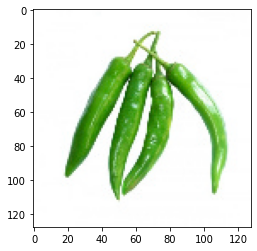

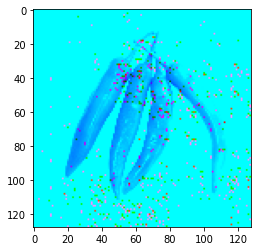

In [230]:
class NewModel(nn.Module):
    def __init__(self, preModel):
        
        super(NewModel, self).__init__()
        
        # pre-model
        self.preModel = preModel

        ## Try 3 Architecture
        self.downsamp1 = nn.Sequential(
                                         nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(32),
                                      )
        self.downsamp1.requires_grad = True

        self.downsamp2 = nn.Sequential(
                                         nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(64),
                                       )
        self.downsamp2.requires_grad = True

        self.upsamp4 = nn.Sequential(
                                        nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2),    
                                        nn.BatchNorm2d(32),
                                       )
        self.upsamp4.requires_grad = True

        self.upsamp5 = nn.Sequential(
                                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2),    
                                        nn.BatchNorm2d(16),
                                       )
        self.upsamp5.requires_grad = True

        self.upsamp6 = nn.Sequential(
                                        nn.ConvTranspose2d(16, 4, kernel_size = 2, stride = 2),    
                                        nn.BatchNorm2d(4),
                                       )
        self.upsamp6.requires_grad = True

        self.upsamp7 = nn.Sequential(
                                        nn.ConvTranspose2d(4, 2, kernel_size = 2, stride = 2),    
                                       )
        self.upsamp7.requires_grad = True

        
        
    def forward(self, x):
        
        x = x.float()
        out = self.preModel.downsamp1(x)
        out = self.preModel.downsamp2(out)
        out = self.preModel.downsamp3(out)
        out = self.preModel.downsamp4(out)
        out = self.preModel.downsamp5(out)
        out = self.preModel.upsamp1(out)
        out = self.preModel.upsamp2(out)
        out = self.preModel.upsamp3(out)
#         out = self.upsamp4(out)
#         out = self.upsamp5(out)
        out = self.downsamp1(out)
        out = self.downsamp2(out)
        out = self.upsamp4(out)
        out = self.upsamp5(out)
        out = self.upsamp6(out)
        out = self.upsamp7(out)
        out = torch.flatten(out, 0, 1)
        
        return out
        
        
#run color regressor
lr = 0.01
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(cModel.parameters(), lr)
path = "./saved_models/color_architecture_9.pt"
preMod = colorer()
preMod.load_state_dict(torch.load(path))
preMod.eval()
preMod.downsamp1.requires_grad=True
preMod.downsamp2.requires_grad=True
preMod.downsamp3.requires_grad=False
preMod.downsamp4.requires_grad=False
preMod.downsamp5.requires_grad=False
preMod.upsamp1.requires_grad=False
preMod.upsamp2.requires_grad=False
preMod.upsamp3.requires_grad=False
preMod.upsamp4.requires_grad=True
preMod.upsamp5.requires_grad=True
sampMod = NewModel(preMod)
trainModel(sampMod, food_train_loader, food_val_loader, optimizer, 80, 'fruit', '18')     
